In [1]:
# Downloading a bunch of data (takes a few minutes)
#!wget https://users.flatironinstitute.org/~flanusse/provabgs_legacysurvey_eval_v2.fits

In [2]:
import torch
import numpy as np
from tqdm import tqdm
from astropy.table import Table


In [3]:
# AION toklenizer
from aion.codecs import CodecManager
codec_manager = CodecManager(device="cuda")

# AION embedder
from aion.model import AION
# Disable gradients for this notebook
torch.set_grad_enabled(False)
model = AION.from_pretrained("polymathic-ai/aion-base").to("cuda").eval()

/home/workshop/aion_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from aion.modalities import (
    LegacySurveyImage,
    DESISpectrum,
    LegacySurveyFluxG,
    LegacySurveyFluxR,
    LegacySurveyFluxI,
    LegacySurveyFluxZ,
    Z,
)

# Loading the data
data = Table.read("provabgs_legacysurvey_eval_v2.fits")


# Define utility function to create modalities from the table
def format_data_modalities(data, device="cuda"):
    """Formats the input data into modality objects."""

    # Helper function
    def to_tensor(data_array, dtype="float32"):
        return torch.tensor(np.array(data_array).astype(dtype), device=device)

    # Create image modality
    image = LegacySurveyImage(
        flux=to_tensor(data["legacysurvey_image_flux"]),
        bands=["DES-G", "DES-R", "DES-I", "DES-Z"],
    )

    # Create spectrum modality
    spectrum = DESISpectrum(
        flux=to_tensor(data["desi_spectrum_flux"]),
        ivar=to_tensor(data["desi_spectrum_ivar"]),
        mask=to_tensor(data["desi_spectrum_mask"], dtype="bool"),
        wavelength=to_tensor(data["desi_spectrum_lambda"]),
    )

    # Create flux modalities
    g = LegacySurveyFluxG(value=to_tensor(data["legacysurvey_FLUX_G"]))
    r = LegacySurveyFluxR(value=to_tensor(data["legacysurvey_FLUX_R"]))
    i = LegacySurveyFluxI(value=to_tensor(data["legacysurvey_FLUX_I"]))
    z = LegacySurveyFluxZ(value=to_tensor(data["legacysurvey_FLUX_Z"]))

    return image, spectrum, g, r, i, z


# Helper function
def to_tensor(data_array, dtype="float32"):
    return torch.tensor(np.array(data_array).astype(dtype), device="cuda")


In [5]:
"""batch_size = 64
im_embeddings = []
sp_embeddings = []
all_embeddings = []

# Loop through the table in batches
for i in tqdm(range(0, 10, batch_size)):
    batch_data = data[i : i + batch_size]

    # Format data into modalities for the current batch
    image, spectrum, g, r, i, z = format_data_modalities(batch_data, device="cuda")

    
    flux=to_tensor(batch_data["legacysurvey_image_flux"])
    print(flux.size())
    for i in range(4):
      array = flux[:,i,:,:].reshape(-1,)
      print(i, torch.mean(array), torch.std(array))

    
    spectrum =to_tensor(data["desi_spectrum_flux"])
    print(torch.mean(spectrum), torch.std(spectrum))
    print(spectrum.size())
   

    # Compute embeddings using the AION model
    im_embeddings.append(
        model.encode(codec_manager.encode(image), num_encoder_tokens=600).mean(axis=1)
    )

    sp_embeddings.append(
        model.encode(codec_manager.encode(spectrum), num_encoder_tokens=300).mean(
            axis=1
        )
    )

    all_embeddings.append(
        model.encode(
            codec_manager.encode(image, g, r, i, z), num_encoder_tokens=900
        ).mean(axis=1)
    )

# Concatenate the embeddings from all batches
im_embeddings = torch.cat(im_embeddings, dim=0).cpu().numpy()
sp_embeddings = torch.cat(sp_embeddings, dim=0).cpu().numpy()
all_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()

print(f"Successfully processed {len(data)} images in batches of {batch_size}.")
print(f"Embeddings shape: {all_embeddings.shape}")
"""

'batch_size = 64\nim_embeddings = []\nsp_embeddings = []\nall_embeddings = []\n\n# Loop through the table in batches\nfor i in tqdm(range(0, 10, batch_size)):\n    batch_data = data[i : i + batch_size]\n\n    # Format data into modalities for the current batch\n    image, spectrum, g, r, i, z = format_data_modalities(batch_data, device="cuda")\n\n\n    flux=to_tensor(batch_data["legacysurvey_image_flux"])\n    print(flux.size())\n    for i in range(4):\n      array = flux[:,i,:,:].reshape(-1,)\n      print(i, torch.mean(array), torch.std(array))\n\n\n    spectrum =to_tensor(data["desi_spectrum_flux"])\n    print(torch.mean(spectrum), torch.std(spectrum))\n    print(spectrum.size())\n\n\n    # Compute embeddings using the AION model\n    im_embeddings.append(\n        model.encode(codec_manager.encode(image), num_encoder_tokens=600).mean(axis=1)\n    )\n\n    sp_embeddings.append(\n        model.encode(codec_manager.encode(spectrum), num_encoder_tokens=300).mean(\n            axis=1\n  

In [6]:


batch_size = 32

num_blocks = len(model.encoder)


def get_embeddings_layer(batch_size):


    im_embeddings = {blk:[] for blk in range(num_blocks + 1)}
    sp_embeddings = {blk:[] for blk in range(num_blocks + 1)}
    all_embeddings = {blk:[] for blk in range(num_blocks + 1)}

    # Loop through the table in batches
    for i in tqdm(range(0, 100, batch_size)):
        batch_data = data[i : i + batch_size]
    
        # Format data into modalities for the current batch
        image, spectrum, g, r, i, z = format_data_modalities(batch_data, device="cuda")

        # manually encode image
        #https://github.com/PolymathicAI/AION/blob/926c5153b2f16829efe1f7ac2ee202759d5ea09b/aion/model.py#L149
        encoder_tokens_im, encoder_emb_im, encoder_mask_im, _ = model.embed_inputs(
            codec_manager.encode(image), mask=None, num_encoder_tokens=600
        )
        x_im = encoder_tokens_im + encoder_emb_im

        # manually encode spectrum
        encoder_tokens_sp, encoder_emb_sp, encoder_mask_sp, _ = model.embed_inputs(
            codec_manager.encode(spectrum), mask=None, num_encoder_tokens=300
        )
        x_sp = encoder_tokens_sp + encoder_emb_sp

        # manually encode both
        encoder_tokens_all, encoder_emb_all, encoder_mask_all, _ = model.embed_inputs(
            codec_manager.encode(image, g, r, i, z), mask=None, num_encoder_tokens=900
        )
        x_all = encoder_tokens_all + encoder_emb_all

        
        for b, blk in enumerate(model.encoder):
            x_im = blk(x_im, mask=encoder_mask_im)
            im_embeddings[b].append(model.encoder_norm(x_im.mean(axis=1)))

            x_sp = blk(x_sp, mask=encoder_mask_sp)
            sp_embeddings[b].append(model.encoder_norm(x_sp.mean(axis=1)))

            x_all = blk(x_all, mask=encoder_mask_all)
            all_embeddings[b].append(model.encoder_norm(x_all.mean(axis=1)))
            
        # output
        x_im = model.encoder_norm(x_im)
        context_im = model.decoder_proj_context(x_im) + encoder_emb_im
        im_embeddings[b + 1].append(context_im.mean(axis=1))

        x_sp = model.encoder_norm(x_sp)
        context_sp = model.decoder_proj_context(x_sp) + encoder_emb_sp
        sp_embeddings[b + 1].append(context_sp.mean(axis=1))

        x_all = model.encoder_norm(x_all)
        context_all = model.decoder_proj_context(x_all) + encoder_emb_all
        all_embeddings[b + 1].append(context_all.mean(axis=1))


   

    # Concatenate the embeddings from all batches
    for b in range(num_blocks + 1):
        
        im_embeddings[b] = torch.cat(im_embeddings[b], dim=0).cpu().numpy()
        sp_embeddings[b] = torch.cat(sp_embeddings[b], dim=0).cpu().numpy()
        all_embeddings[b] = torch.cat(all_embeddings[b], dim=0).cpu().numpy()

  
    print(f"Successfully processed {len(data)} images in batches of {batch_size}.")

    return im_embeddings, sp_embeddings, all_embeddings

In [7]:
im_embeddings, sp_embeddings, all_embeddings= get_embeddings_layer(batch_size)

100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Successfully processed 3815 images in batches of 32.


In [8]:
im_embeddings_dist, sp_embeddings_dist, all_embeddings_dist = [], [], []

for b in range(num_blocks):
    # get l2 norm
    im_embeddings_dist.append(np.linalg.norm(im_embeddings[b] - im_embeddings[b+1], ord = 2,axis = 1).mean())
    sp_embeddings_dist.append(np.linalg.norm(sp_embeddings[b] - sp_embeddings[b+1], ord = 2,axis = 1).mean())
    all_embeddings_dist.append(np.linalg.norm(all_embeddings[b] - all_embeddings[b+1], ord = 2,axis = 1).mean())
    
    


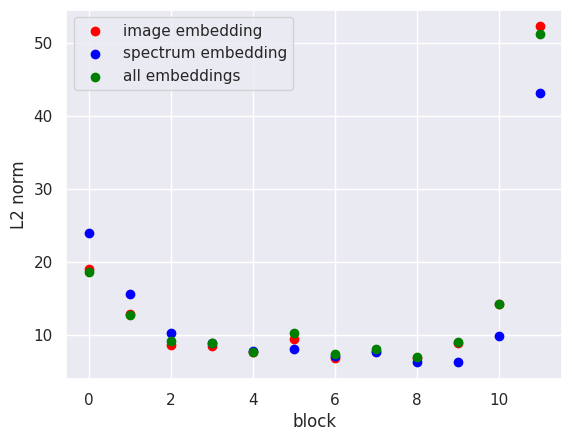

In [11]:
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(range(num_blocks), im_embeddings_dist, color = "red", label = "image embedding")
plt.scatter(range(num_blocks), sp_embeddings_dist, color = "blue", label = "spectrum embedding")
plt.scatter(range(num_blocks), all_embeddings_dist, color = "green", label = "all embeddings")


plt.legend()
plt.xlabel("block")
plt.ylabel("L2 norm")
plt.show()